#kaggle,House Prices - Advanced Regression Techniques 竞赛

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# 明确识别并移除特定异常值
def remove_specific_outliers(data):#去除异常数据方法
    # 创建数据副本
    cleaned_data = data.copy()
    outliers_indices = []

    # 1. 移除GrLivArea > 4000且SalePrice < 300000的异常点
    gla_outliers = data[(data['GrLivArea'] > 4000) & (data['SalePrice'] < 300000)].index
    outliers_indices.extend(gla_outliers)

    # 2. 处理极端价格点
    # 仅移除极端高价格（排除顶级豪宅）
    extreme_price_high = data[data['SalePrice'] > 700000].index
    outliers_indices.extend(extreme_price_high)

    # 3. 对于OverallQual，移除每个质量级别中的极端值
    for qual in range(1, 11):
        if qual in data['OverallQual'].values:
            qual_group = data[data['OverallQual'] == qual]

            # 如果该质量级别样本足够多，使用IQR移除异常值
            if len(qual_group) > 10:  # 确保样本量足够
                Q1 = qual_group['SalePrice'].quantile(0.25)
                Q3 = qual_group['SalePrice'].quantile(0.75)
                IQR = Q3 - Q1

                # 移除极端异常值（使用3*IQR而不是1.5*IQR，更保守）
                qual_outliers = qual_group[(qual_group['SalePrice'] < Q1 - 3*IQR) |
                                          (qual_group['SalePrice'] > Q3 + 3*IQR)].index
                outliers_indices.extend(qual_outliers)

    # 去重
    outliers_indices = list(set(outliers_indices))
    print(f"共识别出 {len(outliers_indices)} 个异常值")

    # 移除异常值
    cleaned_data = cleaned_data.drop(outliers_indices)
    print(f"数据清洗前: {data.shape}, 数据清洗后: {cleaned_data.shape}")

    return cleaned_data, outliers_indices

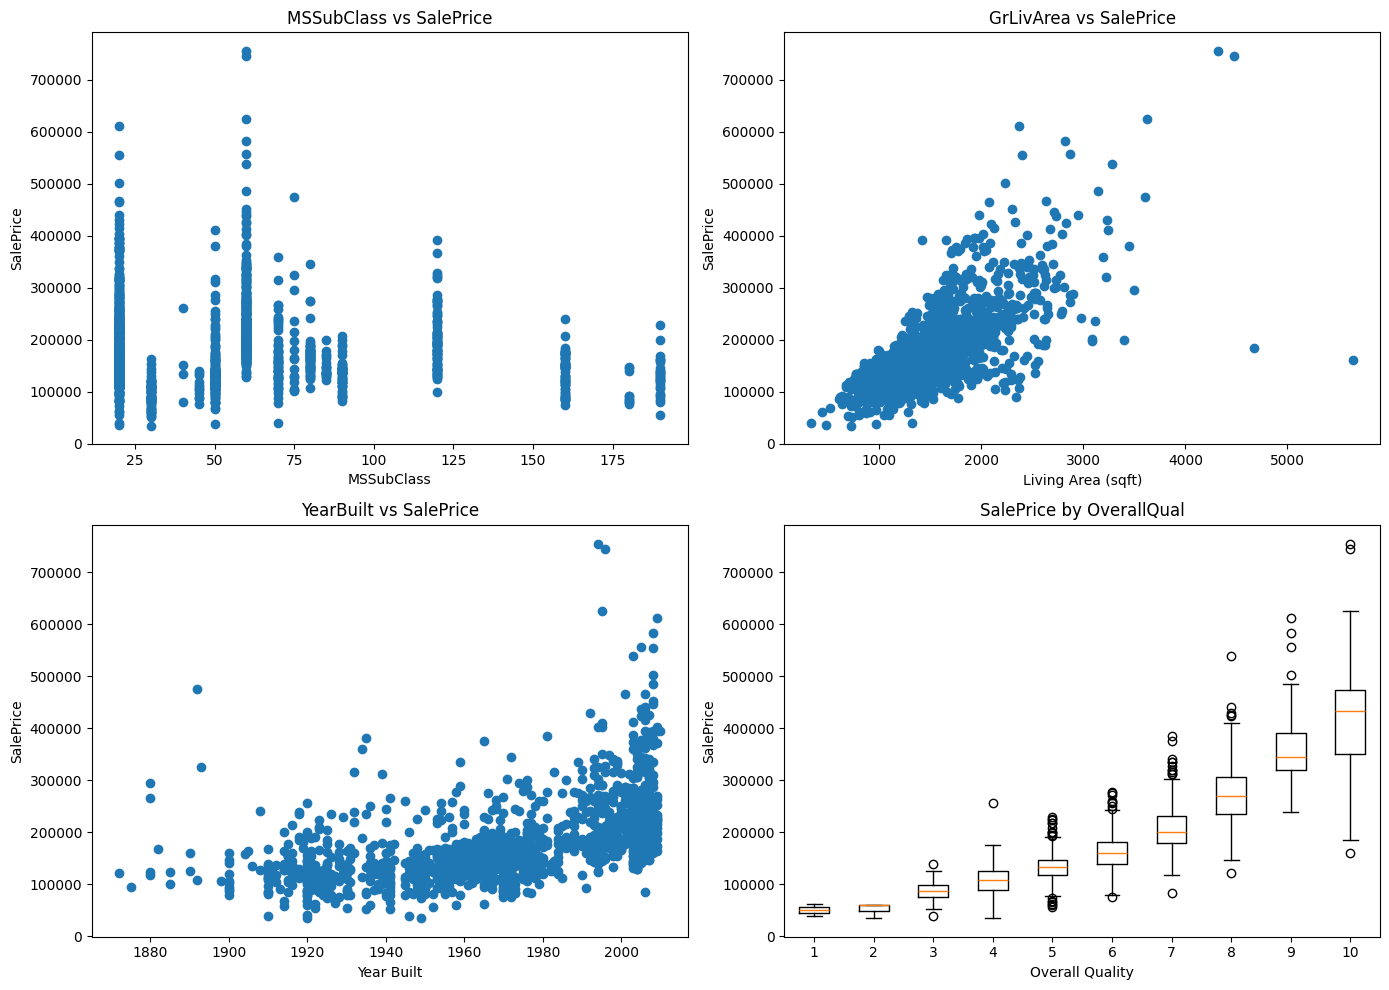

In [3]:
#寻找特征和价格关系最大的参数
import matplotlib.pyplot as plt
import pandas as pd

dataset = pd.read_csv('train.csv')

# 创建2x2的子图网格
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 子图1：MSSubClass vs SalePrice散点图
axes[0, 0].scatter(dataset["MSSubClass"], dataset['SalePrice'])
axes[0, 0].set_title('MSSubClass vs SalePrice')
axes[0, 0].set_xlabel('MSSubClass')
axes[0, 0].set_ylabel('SalePrice')

# 子图2：GrLivArea vs SalePrice散点图
axes[0, 1].scatter(dataset["GrLivArea"], dataset['SalePrice'])
axes[0, 1].set_title('GrLivArea vs SalePrice')
axes[0, 1].set_xlabel('Living Area (sqft)')
axes[0, 1].set_ylabel('SalePrice')

# 子图3：YearBuilt vs SalePrice散点图
axes[1, 0].scatter(dataset["YearBuilt"], dataset['SalePrice'])
axes[1, 0].set_title('YearBuilt vs SalePrice')
axes[1, 0].set_xlabel('Year Built')
axes[1, 0].set_ylabel('SalePrice')

# 子图4：OverallQual vs SalePrice的箱线图
axes[1, 1].boxplot([dataset[dataset['OverallQual']==i]['SalePrice'] for i in range(1, 11) if i in dataset['OverallQual'].values])
axes[1, 1].set_title('SalePrice by OverallQual')
axes[1, 1].set_xlabel('Overall Quality')
axes[1, 1].set_ylabel('SalePrice')

# 调整布局以避免重叠
plt.tight_layout()
plt.show()

In [4]:

data = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
print(data.shape)
print(data_test.shape)


data, outliers = remove_specific_outliers(data) #去除异常值

# 特征工程合并添加几个参数提高特征获取，提升准确率
def quick_features(data):
    # 保留高价值特征
    data['QualArea'] = data['OverallQual'] * data['GrLivArea']  # 最高相关性
    data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']
    data['TotalBath'] = data['FullBath'] + data['HalfBath'] * 0.5
    # 删除HouseAge，它只是YearBuilt的线性变换，不添加新信息
    # 删除HasGarage，因为GarageCars和GarageArea提供更好的信息
    return data



# 2. 对训练集和测试集都做特征工程
enhance_data = quick_features(data)
enhance_test = quick_features(data_test)  # 这一步很重要！


train_features = enhance_data.drop(['Id'], axis=1)
eval_train, eval_test = train_test_split(train_features, test_size=0.2, random_state=42, shuffle=True)#训练集分出20%用于测试，因为测试机没有label


(1460, 81)
(1459, 80)
共识别出 7 个异常值
数据清洗前: (1460, 81), 数据清洗后: (1453, 81)


In [15]:

print(enhance_data.shape)
print(eval_train.shape)
print(eval_test.shape)
print(enhance_test.shape)


(1453, 84)
(1162, 83)
(291, 83)
(1459, 83)


In [19]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# 准备数据
X_train = eval_train.drop(['SalePrice'], axis=1)
y_train = eval_train['SalePrice']
X_test = eval_test.drop(['SalePrice'], axis=1)
y_test = eval_test['SalePrice']
X_test_data = enhance_test.drop(['Id'], axis=1)
test_ids = enhance_test['Id']

# 识别分类特征
cat_features = [col for col in X_train.columns if X_train[col].dtype == 'object']
cat_indices = [i for i, col in enumerate(X_train.columns) if col in cat_features]

# 1. 填充分类特征中的缺失值
for col in cat_features:
    # 用一个特殊的字符串替换NaN值，比如'Missing'
    X_train[col] = X_train[col].fillna('Missing')
    X_test[col] = X_test[col].fillna('Missing')
    X_test_data[col] = X_test_data[col].fillna('Missing')

# 2. 对于数值特征中的缺失值，CatBoost可以自动处理，但最好也填充
num_features = [col for col in X_train.columns if X_train[col].dtype != 'object']
for col in num_features:
    # 用中位数填充数值型特征的缺失值
    median_value = X_train[col].median()
    X_train[col] = X_train[col].fillna(median_value)
    X_test[col] = X_test[col].fillna(median_value)
    X_test_data[col] = X_test_data[col].fillna(median_value)

# 获取分类特征的索引
cat_indices = [i for i, col in enumerate(X_train.columns) if col in cat_features]

# 打印一些信息，以便于调试
print(f"总特征数: {len(X_train.columns)}")
print(f"分类特征数: {len(cat_features)}")
print(f"分类特征索引: {cat_indices}")

# 检查是否还有缺失值
print(f"训练集中的缺失值总数: {X_train.isnull().sum().sum()}")
print(f"验证集中的缺失值总数: {X_test.isnull().sum().sum()}")
print(f"测试集中的缺失值总数: {X_test_data.isnull().sum().sum()}")


# 初始化CatBoost模型
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',
    cat_features=cat_indices,
    random_seed=42
)

# 训练模型
model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=200)



总特征数: 82
分类特征数: 43
分类特征索引: [1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 34, 38, 39, 40, 41, 52, 54, 56, 57, 59, 62, 63, 64, 71, 72, 73, 77, 78]
训练集中的缺失值总数: 0
验证集中的缺失值总数: 0
测试集中的缺失值总数: 0
0:	learn: 73616.7419727	test: 70125.6285253	best: 70125.6285253 (0)	total: 84.6ms	remaining: 1m 24s
200:	learn: 16053.9709956	test: 19854.4144231	best: 19854.4144231 (200)	total: 7.84s	remaining: 31.2s
400:	learn: 12646.3124694	test: 19145.5821814	best: 19143.2000575 (394)	total: 14s	remaining: 20.9s
600:	learn: 10203.8623111	test: 18833.8387380	best: 18833.1151434 (599)	total: 21.6s	remaining: 14.3s
800:	learn: 8328.2221406	test: 18726.3867529	best: 18726.3867529 (800)	total: 27.7s	remaining: 6.89s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 18647.41405
bestIteration = 941

Shrink model to first 942 iterations.


In [20]:
# 评估模型
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")


RMSE: 18647.41


In [21]:

# 对测试集进行预测
test_predictions = model.predict(X_test_data)


In [22]:

# 创建提交文件
submission = pd.DataFrame({'Id': test_ids, 'SalePrice': test_predictions})
submission.to_csv('catboost_submission.csv', index=False)
print("预测完成，结果已保存到 catboost_submission.csv")

预测完成，结果已保存到 catboost_submission.csv
